# Study of Automated Shuttle Interactions in City Traffic Using Surrogate Measures of Safety

## Author
Étienne Beauchamp  
M.A.Sc. candidate, Department of Civil, Geological and Mining Engineering  
Polytechnique Montréal, C.P. 6079, succ. Centre-Ville  
Montréal (Québec) Canada H3C 3A7  
Phone: (514) 340-4711 ext. 4210  
Email: etienne-2.beauchamp@polymtl.ca

## Overview
This code was written as part of a research study. It uses methods from the TrafficIntelligence Python module to analyze data extracted from video recordings.

Before getting started, you will need to install the following:
* Python 3 (3.7.3 was used here);
* [Pandas](https://pandas.pydata.org/);
* [Seaborn](https://seaborn.pydata.org/);
* [Matplotlib](https://matplotlib.org/);
* [SciPy](https://docs.scipy.org/doc/scipy/reference/stats.html);
* [NumPy](https://numpy.org/);
* [Statsmodels](https://www.statsmodels.org/).

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
from distutils import util
from scipy import stats
import numpy as np
import statsmodels.formula.api as smf

c:\users\etienne\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
pd.set_option('display.max_columns', None)  # Show all columns in dataframe when displayed
sns.set()

## Speed and Acceleration data

In [3]:
speedAcc = pd.read_csv("data/speed-acceleration.csv")

In [4]:
speedAcc = speedAcc[speedAcc['av'].notnull()]  # analyzing only interactions with AV or control vehicles
speedAcc.av = speedAcc.av.astype(int)

In [5]:
speedAcc.head()

,Unnamed: 0,site,time,dbName,num,speed,acc,av
24,24,letourneux-coubertin,2019-07-03T10:30,2019-07-03T10:26-04:00.sqlite,86,7.682097,0.020747,1
131,131,letourneux-coubertin,2019-07-03T10:51,2019-07-03T10:46-04:00.sqlite,81,6.784812,-0.007110,1
133,133,letourneux-coubertin,2019-07-03T10:52,2019-07-03T10:46-04:00.sqlite,87,4.140178,0.006168,1
144,144,letourneux-coubertin,2019-07-03T10:54,2019-07-03T10:46-04:00.sqlite,117,36.893121,-1.661836,0
179,179,letourneux-coubertin,2019-07-03T10:59,2019-07-03T10:46-04:00.sqlite,219,8.786557,0.032888,1


## Headway data

In [6]:
headway = pd.read_csv("data/headway.csv")

In [7]:
# Changing the type of user 0 (unknown) with 4 (bicycle) (they were electric scooter)
headway.loc[headway["leading_user_type"] == 0, ["leading_user_type"]] = 1
# Changing the type of users 3 (motorcycle), 5 (bus) and 6 (truck) with 1 (car)
headway.loc[headway["leading_user_type"].isin([3, 5, 6]), ["leading_user_type"]] = 1
# Changing the type of user 0 (unknown) with 4 (bicycle) (they were electric scooter)
headway.loc[headway["other_user_type"] == 0, ["other_user_type"]] = 4
# Changing the type of users 3 (motorcycle), 5 (bus) and 6 (truck) with 1 (car)
headway.loc[headway["other_user_type"].isin([3, 5, 6]), ["other_user_type"]] = 1

In [8]:
headway.head()

,hwt_15,hwt_min,leading_user_type,following_user_type,overtaking,av,other_user_type,hour,minutes,date,traffic_light,site,city,u1_min_speed,u1_max_speed,u2_min_speed,u2_max_speed,u1_min_15_acc,u1_max_85_acc,u2_min_15_acc,u2_max_85_acc,nb_users_15_s,nb_users_30_s,pedestrian_15_s,pedestrian_30_s,cyclist_15_s,cyclist_30_s
0,8.000000,7.866667,1,1,0.0,NaN,1,12,39,2019-11-27,0,montcalm-chartwell,0,1.715568,67.503592,2.775750,69.268291,-4.348393,0.804480,-4.545057,0.265805,7,11,0,0,0,0
1,14.300000,14.266667,1,1,0.0,NaN,1,12,39,2019-11-27,0,montcalm-chartwell,0,3.878439,65.085572,1.715568,67.503592,-4.176515,0.755327,-4.348393,0.804480,6,10,0,0,0,0
2,9.965000,9.033333,1,1,0.0,NaN,1,12,39,2019-11-27,0,montcalm-chartwell,0,2.315543,37.650846,3.878439,65.085572,-2.059706,0.996058,-4.176515,0.755327,5,11,0,0,0,0
3,16.166667,14.133333,1,1,0.0,NaN,1,12,39,2019-11-27,0,montcalm-chartwell,0,1.637026,57.385169,2.315543,37.650846,-3.750774,0.440723,-2.059706,0.996058,6,11,0,0,0,0
4,2.900000,2.066667,1,1,0.0,NaN,1,12,39,2019-11-27,0,montcalm-chartwell,0,3.771917,54.478483,1.637026,57.385169,-3.425761,0.812189,-3.750774,0.440723,6,11,0,0,0,0


## Safety indicators data

In [9]:
petTtcSpeedDiff = pd.read_csv("data/pet-ttc-speeddiff.csv")

In [10]:
petTtcSpeedDiff = petTtcSpeedDiff[petTtcSpeedDiff['av'].notnull()]
petTtcSpeedDiff.av = petTtcSpeedDiff.av.astype(int)
petTtcSpeedDiff.speed_diff_max = 3.6*30*petTtcSpeedDiff.speed_diff_max

In [11]:
petTtcSpeedDiff.head()

,pet,ttc_15,av,other_user_type,most_frequent_category,second_most_frequent_category,hour,minutes,date,duration,traffic_light,site,city,u1_min_speed,u1_max_speed,u2_min_speed,u2_max_speed,u1_min_15_acc,u1_max_85_acc,u2_min_15_acc,u2_max_85_acc,speed_diff_max,collision_prob_max,nb_users_15_s,nb_users_30_s,pedestrian_15_s,pedestrian_30_s,cyclist_15_s,cyclist_30_s,interaction_id
38,1.333333,1.893880,1,1,2.0,NaN,10,30,7/3/2019,72,1,letourneux-coubertin,1,0.602914,12.308526,0.780896,120.993665,-0.817117,0.893447,0.392934,3.228695,6.093162,237250.0,6,10,1,1,0,0,49
242,17.166667,4.321079,1,4,2.0,NaN,10,51,7/3/2019,129,1,letourneux-coubertin,1,1.872844,12.022772,12.592445,21.685661,-0.895160,0.887989,-1.151356,0.322414,21.301162,131880.0,3,10,1,1,1,1,24
243,3.666667,3.503320,1,2,2.0,NaN,10,51,7/3/2019,92,1,letourneux-coubertin,1,1.872844,12.022772,5.834739,12.682964,-0.895160,0.887989,-2.680293,3.213503,7.582267,24670442.0,7,7,1,1,1,1,25
245,NaN,0.800546,1,1,NaN,NaN,10,52,7/3/2019,31,1,letourneux-coubertin,1,2.335359,6.361629,2.617622,10.177445,-1.218444,1.269989,-3.322962,1.834071,9.901730,15810722.0,6,10,1,1,0,1,27
246,NaN,NaN,1,2,2.0,3.0,10,52,7/3/2019,34,1,letourneux-coubertin,1,2.335359,6.361629,4.471168,20.635238,-1.218444,1.269989,-2.771165,5.696931,1.591093,NaN,6,10,1,1,0,1,28


### Violin plot

In [12]:
def addNumberOfObservations(medians, nobs, xOffsetDivide, yOffset):
    # Execute for each subplot
    for ax in plt.gcf().axes:
        # Iterate through all the labels
        for tick, label in enumerate(ax.get_xticklabels()):
            # Retrieve x label (intersection name)
            axIntersection = label.get_text()
            for j, axLeadingUserType in enumerate(ax.get_legend_handles_labels()[1]):
                # Offset to the left or right of the split for each distribution (+- 0.0769)
                xOffset = (j - 0.5) * 2/xOffsetDivide
                # Get median and number of observations
                try:
                    # Get median and number of observations
                    medVal = medians[axIntersection, int(axLeadingUserType)]
                    num = nobs[axIntersection, int(axLeadingUserType)]
                    # Add white text with the information
                    ax.text(tick + xOffset, medVal + yOffset, num, horizontalalignment="center", size="x-small", color="black", weight="semibold")
                except KeyError:
                    print("No observations")

def violinPlot(df, fileName, yLabelName, hue, yMin, yMax):
    plt.ylim(yMin, yMax)
    ax = sns.violinplot(x="site", y=yLabelName, hue=hue, data=df, split=True, inner="quartile", cut=0)
    
    # Number of observations for each distribution
    medians = df.groupby(["site", hue])[yLabelName].median()
    nobs = df.groupby(["site", hue]).count()[yLabelName].apply(lambda x: "n: {}".format(x))
    
    # Retrive all medians and numbers for each intersection to write to plot
    if yLabelName == "speed":
        yLabelName = "Mean speed (km/h)"
        yOffset = 0.1
    elif yLabelName == "acc":
        yLabelName = "Mean acceleration ($m/s^2$)"
        yOffset = 0.1
    elif yLabelName == "hwt_15":
        yLabelName = "$h_{15}$ (s)"
        yOffset = 0.01
    elif yLabelName == "ttc_15":
        yLabelName = "$TTC_{15}$ (s)"
        yOffset = 0.05
    elif yLabelName == "pet":
        yLabelName = "$PET$ (s)"
        yOffset = 0.2
    elif yLabelName == "speed_diff_max":
        yLabelName = "$\Delta v_{85}$ (km/h)"
        yOffset = 0.2
        
    addNumberOfObservations(medians, nobs, 9, yOffset)
    
    # Set legend
    handles, labels = ax.figure.get_axes()[0].get_legend_handles_labels()
    ax.figure.get_axes()[0].legend([handles[0], handles[1]], ["control", "AV"], loc="upper left")
    ax.set(xlabel='Sites', ylabel=yLabelName)
    
    plt.savefig("imgs/" + fileName + ".pdf", format="pdf", bbox_inches='tight', pad_inches=0)
    plt.show()
    
def ksTest(df, yLabelName, hue):
    tableSite = " "
    tableD = "D (k-s statitic)"
    tableP = "p-value"

    locations = list(df.site.unique())
    
    # K-S test for all intersections
    for site in locations:
        # isolate distribution for AV and control vehicles
        dist1 = df.loc[(df[hue] == df[hue].unique()[0]) & (df.site == site)]
        dist2 = df.loc[(df[hue] == df[hue].unique()[1]) & (df.site == site)]
        D_statistic, p_value = stats.ks_2samp(dist1[yLabelName], dist2[yLabelName])
        # Add values to table
        tableSite += " & {}".format(site)
        tableD += " & {:.4}".format(D_statistic)
        tableP += " & {:.4}".format(p_value) 

    print(tableSite + " \\\ \hline \n" + tableD + " \\\ \hline \n" + tableP + " \\\ \hline")

#### Speed distributions

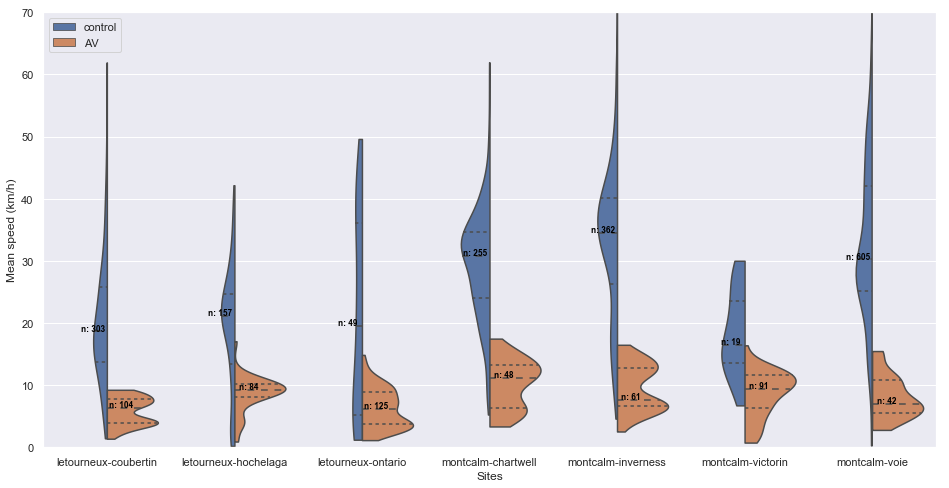

In [13]:
plt.figure(figsize=(16, 8))
violinPlot(speedAcc, "speed_av_vs_similar", "speed", "av", 0, 70)

##### Kolmogorov–Smirnov test

In [14]:
ksTest(speedAcc, "speed", "av")

  & letourneux-coubertin & letourneux-hochelaga & letourneux-ontario & montcalm-chartwell & montcalm-inverness & montcalm-victorin & montcalm-voie \\ \hline 
D (k-s statitic) & 0.8845 & 0.7541 & 0.5634 & 0.9137 & 0.8814 & 0.7981 & 0.9107 \\ \hline 
p-value & 1.332e-15 & 0.0 & 6.662e-11 & 7.772e-16 & 2.22e-16 & 7.563e-11 & 1.11e-15 \\ \hline


#### Acceleration distributions

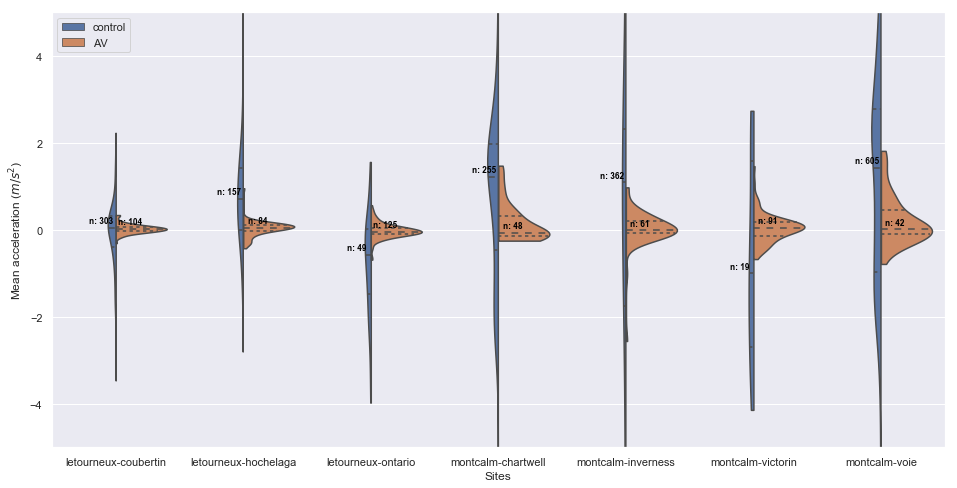

In [15]:
plt.figure(figsize=(16, 8))
violinPlot(speedAcc, "acceleration_av_vs_similar", "acc", "av", -5, 5)

##### Kolmogorov–Smirnov test

In [16]:
ksTest(speedAcc, "acc", "av")

  & letourneux-coubertin & letourneux-hochelaga & letourneux-ontario & montcalm-chartwell & montcalm-inverness & montcalm-victorin & montcalm-voie \\ \hline 
D (k-s statitic) & 0.3405 & 0.6777 & 0.5722 & 0.5221 & 0.5197 & 0.546 & 0.4542 \\ \hline 
p-value & 1.707e-08 & 0.0 & 2.924e-11 & 1.127e-10 & 1.511e-13 & 6.654e-05 & 6.598e-08 \\ \hline


#### Time Headway distributions

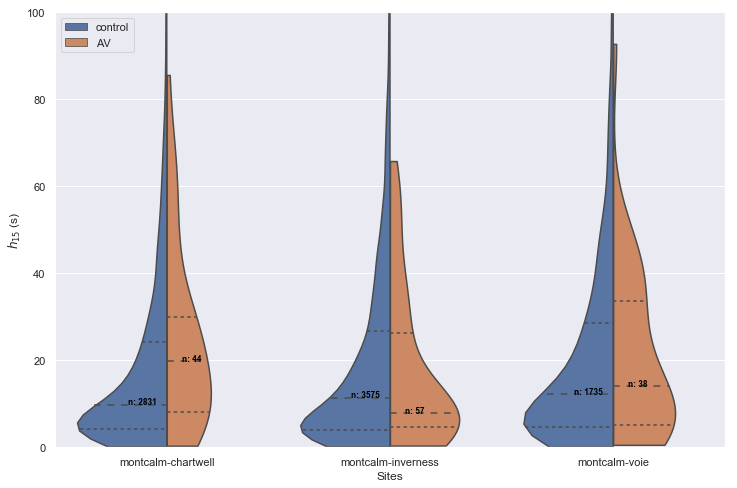

In [17]:
plt.figure(figsize=(12, 8))
violinPlot(headway, "hwt_15_av_lead_vs_car", "hwt_15", "leading_user_type", 0, 100)

##### Kolmogorov–Smirnov test

In [18]:
ksTest(headway, "hwt_15", "leading_user_type")

  & montcalm-chartwell & montcalm-inverness & montcalm-voie \\ \hline 
D (k-s statitic) & 0.2327 & 0.1155 & 0.1071 \\ \hline 
p-value & 0.009835 & 0.3803 & 0.7199 \\ \hline


#### Time-to-Collision (TTC) distributions

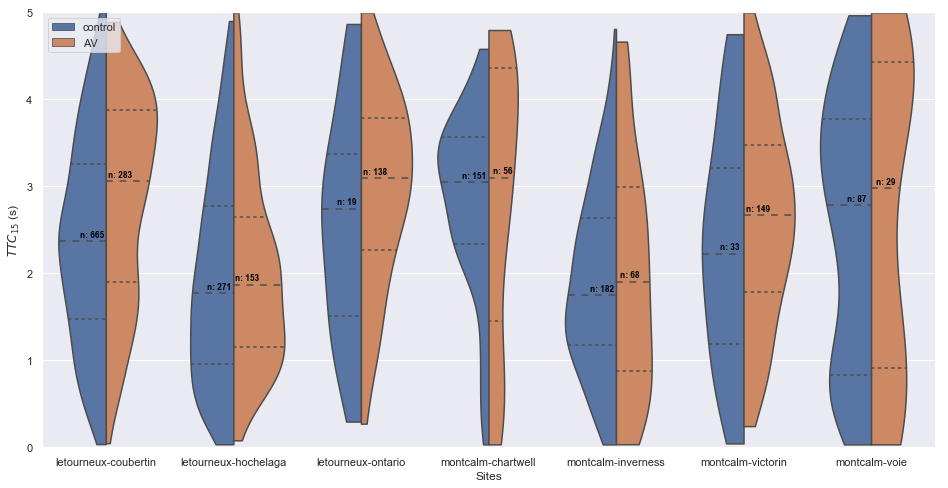

In [19]:
plt.figure(figsize=(16, 8))
violinPlot(petTtcSpeedDiff, "ttc_15_av_vs_similar", "ttc_15", "av", 0, 5)

##### Kolmogorov–Smirnov test

In [20]:
ksTest(petTtcSpeedDiff, "ttc_15", "av")

  & letourneux-coubertin & letourneux-hochelaga & letourneux-ontario & montcalm-chartwell & montcalm-inverness & montcalm-victorin & montcalm-voie \\ \hline 
D (k-s statitic) & 0.1662 & 0.1189 & 0.1559 & 0.244 & 0.1061 & 0.2283 & 0.2314 \\ \hline 
p-value & 3.134e-07 & 0.06811 & 0.4319 & 0.003027 & 0.2022 & 0.04636 & 0.03217 \\ \hline


#### Post-Encroachment Time (PET) distributions

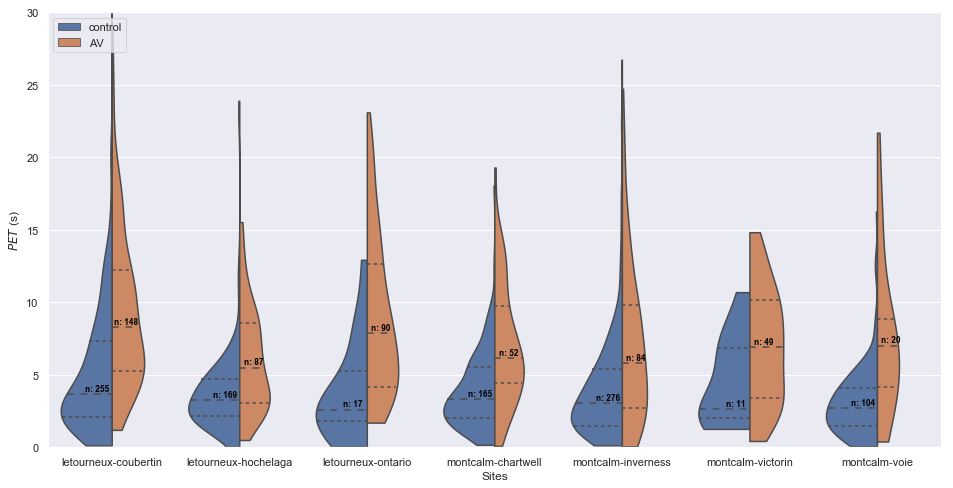

In [21]:
plt.figure(figsize=(16, 8))
violinPlot(petTtcSpeedDiff, "pet_av_vs_similar", "pet", "av", 0, 30)

##### Kolmogorov–Smirnov test

In [22]:
ksTest(petTtcSpeedDiff, "pet", "av")

  & letourneux-coubertin & letourneux-hochelaga & letourneux-ontario & montcalm-chartwell & montcalm-inverness & montcalm-victorin & montcalm-voie \\ \hline 
D (k-s statitic) & 0.1072 & 0.2103 & 0.2778 & 0.426 & 0.3842 & 0.1307 & 0.6189 \\ \hline 
p-value & 0.002912 & 5.541e-05 & 0.01767 & 3.998e-09 & 1.988e-13 & 0.5511 & 9.426e-14 \\ \hline


#### Speed Differential distributions

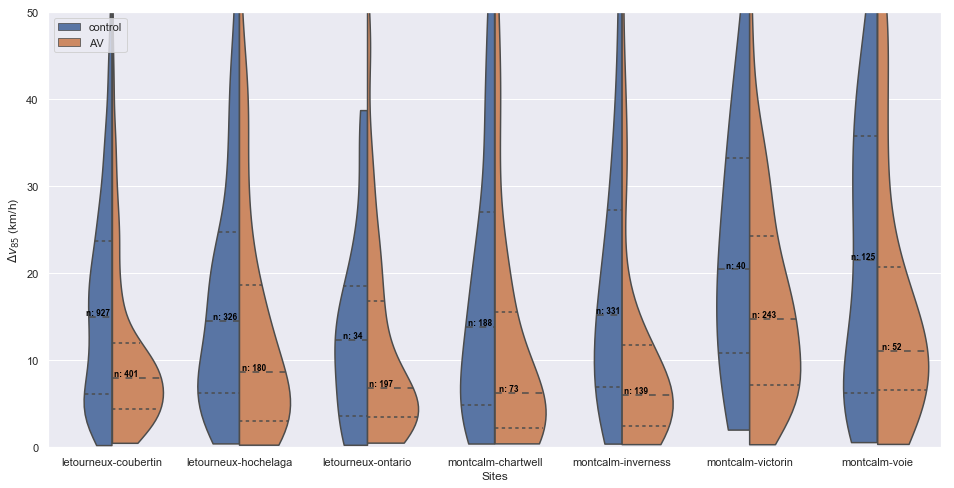

In [23]:
plt.figure(figsize=(16, 8))
violinPlot(petTtcSpeedDiff, "speed_diff_av_vs_similar", "speed_diff_max", "av", 0, 50)

##### Kolmogorov–Smirnov test

In [24]:
ksTest(petTtcSpeedDiff, "speed_diff_max", "av")

  & letourneux-coubertin & letourneux-hochelaga & letourneux-ontario & montcalm-chartwell & montcalm-inverness & montcalm-victorin & montcalm-voie \\ \hline 
D (k-s statitic) & 0.3377 & 0.1766 & 0.2714 & 0.2699 & 0.3908 & 0.1958 & 0.262 \\ \hline 
p-value & 7.772e-16 & 0.001212 & 0.02211 & 0.0007107 & 6.894e-14 & 0.1235 & 0.01006 \\ \hline


### Regression Analysis

In [25]:
# Removing useless columns
# petTtcSpeedDiff = petTtcSpeedDiff.drop(['minutes'], axis=1)
# Removing interactions of less than a third of a second
petTtcSpeedDiff = petTtcSpeedDiff[petTtcSpeedDiff.duration > 10]
# Changing the type of user 0 (unknown) with 1 (car)
petTtcSpeedDiff.loc[petTtcSpeedDiff["other_user_type"] == 0, ["other_user_type"]] = 1
# Changing the type of users 3 (motorcycle), 5 (bus) and 6 (truck) with 1 (car)
petTtcSpeedDiff.loc[petTtcSpeedDiff["other_user_type"].isin([3, 5, 6]), ["other_user_type"]] = 1
# Adding minimum and maximum speed of the interactions
petTtcSpeedDiff['interaction_max_speed'] = petTtcSpeedDiff[['u1_max_speed', 'u2_max_speed']].max(axis=1)
petTtcSpeedDiff['interaction_min_speed'] = petTtcSpeedDiff[['u1_min_speed', 'u2_min_speed']].min(axis=1)
# Creating variable "intersection" if the site is a crossroads
petTtcSpeedDiff['intersection'] = np.where((petTtcSpeedDiff['site'] == 'letourneux-coubertin') |
                                           (petTtcSpeedDiff['site'] == 'letourneux-hochelaga') |
                                           (petTtcSpeedDiff['site'] == 'montcalm-inverness') |
                                           (petTtcSpeedDiff['site'] == 'montcalm-victorin'), 1, 0)

# --- Changing values to category name ---
# other_user_type
petTtcSpeedDiff.loc[petTtcSpeedDiff["other_user_type"] == 1, ["other_user_type"]] = "car"
petTtcSpeedDiff.loc[petTtcSpeedDiff["other_user_type"] == 2, ["other_user_type"]] = "pedestrian"
petTtcSpeedDiff.loc[petTtcSpeedDiff["other_user_type"] == 4, ["other_user_type"]] = "bicycle"
petTtcSpeedDiff.loc[petTtcSpeedDiff["other_user_type"] == 7, ["other_user_type"]] = "automated"
# most_frequent_category
petTtcSpeedDiff.loc[petTtcSpeedDiff["most_frequent_category"] == 0, ["most_frequent_category"]] = "side"  # changed from "headon" because of inconsistencies with categorization
petTtcSpeedDiff.loc[petTtcSpeedDiff["most_frequent_category"] == 1, ["most_frequent_category"]] = "rearend"
petTtcSpeedDiff.loc[petTtcSpeedDiff["most_frequent_category"] == 2, ["most_frequent_category"]] = "side"
petTtcSpeedDiff.loc[petTtcSpeedDiff["most_frequent_category"] == 3, ["most_frequent_category"]] = "sideleaving"  # "parallel" Changed because it wasn't purely parallel interaction and they were very few observations, influencing results too much
petTtcSpeedDiff.loc[petTtcSpeedDiff["most_frequent_category"].isnull(), ["most_frequent_category"]] = "sideleaving"
# second_most_frequent_category
petTtcSpeedDiff.loc[petTtcSpeedDiff["second_most_frequent_category"] == 0, ["second_most_frequent_category"]] = "headon"
petTtcSpeedDiff.loc[petTtcSpeedDiff["second_most_frequent_category"] == 1, ["second_most_frequent_category"]] = "rearend"
petTtcSpeedDiff.loc[petTtcSpeedDiff["second_most_frequent_category"] == 2, ["second_most_frequent_category"]] = "side"
petTtcSpeedDiff.loc[petTtcSpeedDiff["second_most_frequent_category"] == 3, ["second_most_frequent_category"]] = "parallel"
petTtcSpeedDiff.loc[petTtcSpeedDiff["second_most_frequent_category"].isnull(), ["second_most_frequent_category"]] = "other"
# traffic_light
petTtcSpeedDiff.loc[petTtcSpeedDiff["traffic_light"] == 1, ["traffic_light"]] = "yes"
petTtcSpeedDiff.loc[petTtcSpeedDiff["traffic_light"] == 0, ["traffic_light"]] = "no"
# city
petTtcSpeedDiff.loc[petTtcSpeedDiff["city"] == 1, ["city"]] = "montreal"
petTtcSpeedDiff.loc[petTtcSpeedDiff["city"] == 0, ["city"]] = "candiac"

# Data to be analyzed
pd.options.mode.chained_assignment = None  # default='warn'
petTtcSpeedDiff = petTtcSpeedDiff[petTtcSpeedDiff['av'].notnull()]
petTtcSpeedDiff.av = petTtcSpeedDiff.av.astype(int)

# # Removing interactions between two AVs
petTtcSpeedDiff = petTtcSpeedDiff.drop(petTtcSpeedDiff.loc[petTtcSpeedDiff.other_user_type == "automated"].index)

In [26]:
# import seaborn as sn
def showCorrelationMatrix(correlation):
    matplotlib.rcParams['figure.figsize'] = [20, 20]  # Larger figure
    plt.matshow(correlation, cmap='RdBu')
    # Loop over data dimensions and create text annotations.à
    arrayDataframe = np.array(correlation)
    for x, y in np.ndindex(arrayDataframe.shape):
        plt.text(x, y, '{:0.2f}'.format(arrayDataframe[x, y]), ha='center', va='center')
    
    # Colorbar parameters
    plt.clim(-1.,1.)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.xticks(range(len(correlation.columns)), correlation.columns, rotation=90)
    plt.yticks(range(len(correlation.columns)), correlation.columns)
    
def computeCorrelationMatrix(dataFrame, dependentVariable, method='pearson'):
    correlation = dataFrame.corr(method)
    return correlation.loc[dependentVariable]

def showResidualPlot(fittedModel):
    matplotlib.rcParams['figure.figsize'] = [20, 10]
    plt.scatter(fittedModel.fittedvalues, fittedModel.resid)
    plt.xlabel('Valeurs prédites')
    plt.ylabel('Résidus')
    # Setting axis to show all values and be centered at zero
    x1,x2,y1,y2 = plt.axis()
    y2 = abs(max([y1, y2], key=abs))
    y1 = -y2
    plt.axis((x1,x2,y1,y2))
    plt.axhline(y=0, linewidth=0.5, color='grey')

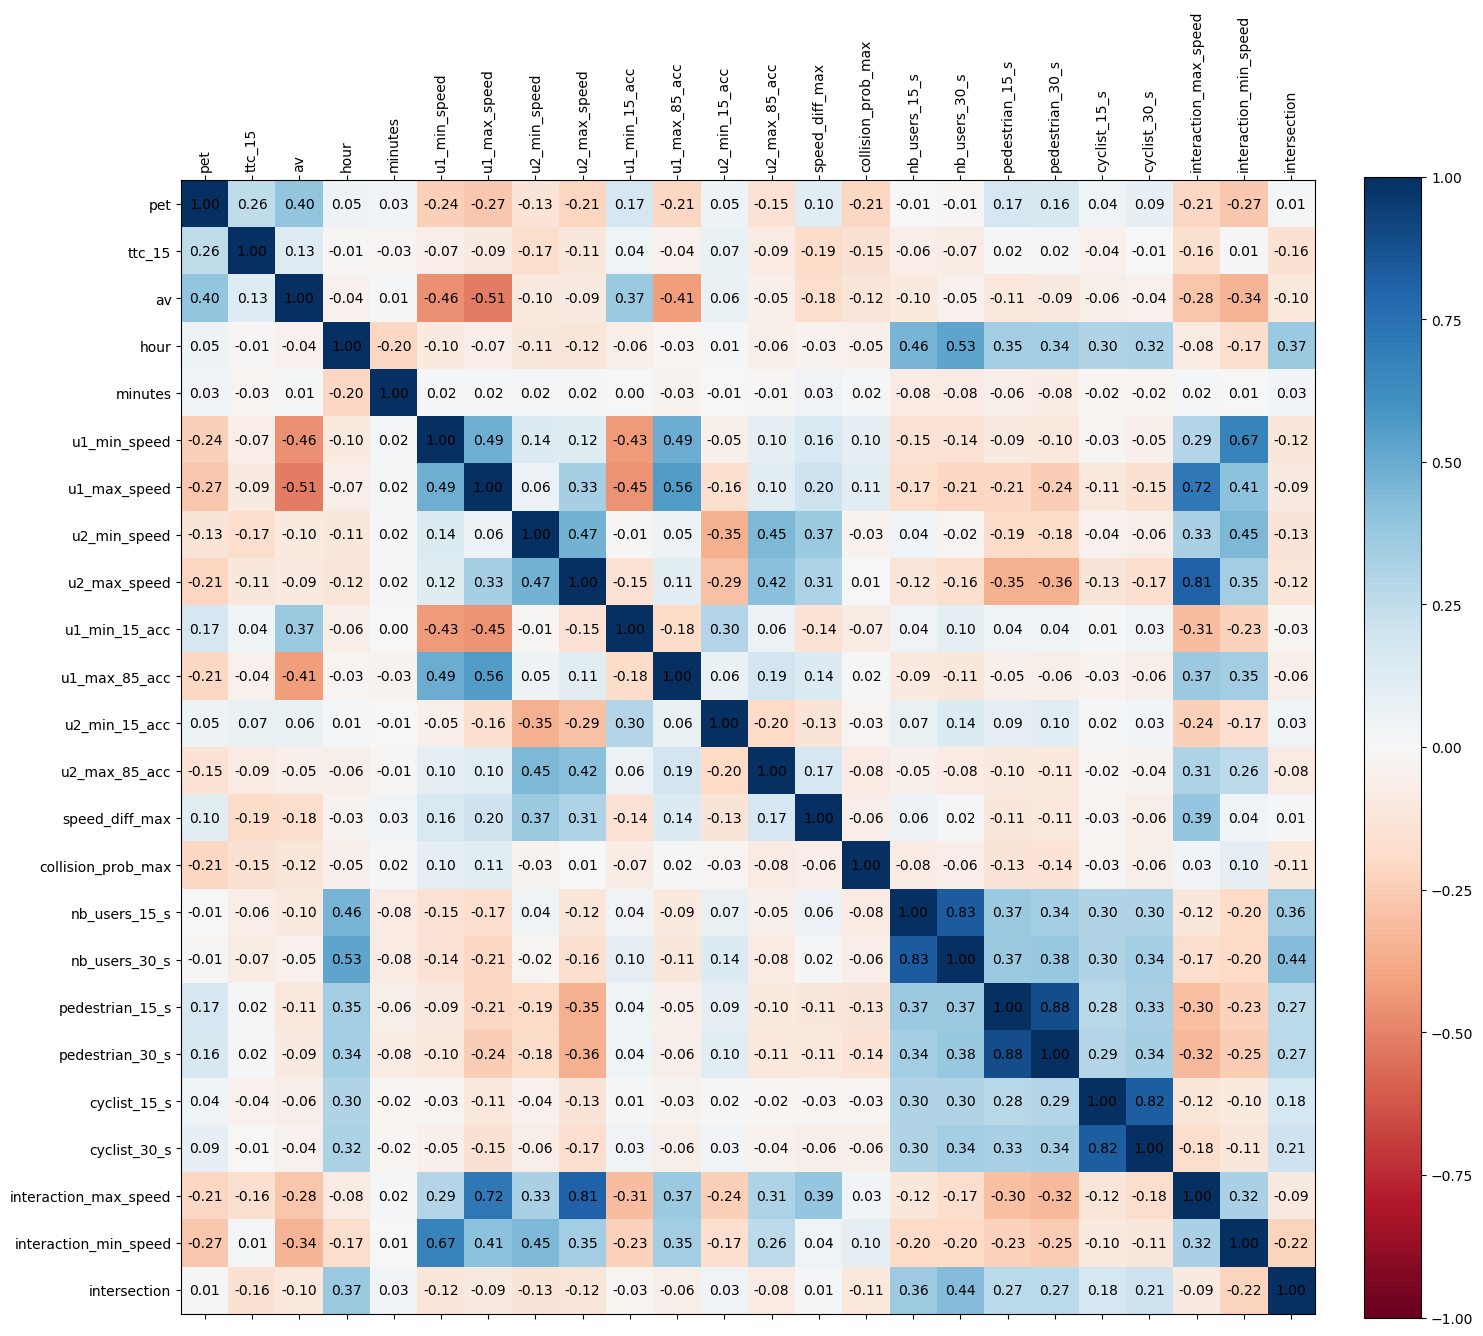

In [27]:
sns.reset_orig()

# Non binary categorical variables to be excluded
categoricalVariables = ['other_user_type', 'most_frequent_category', 'second_most_frequent_category', 
                        'date', 'duration', 'traffic_light', 'site', 'city']
categoricalVariables.append('interaction_id')

showCorrelationMatrix(petTtcSpeedDiff[petTtcSpeedDiff.columns.drop(categoricalVariables)].corr())
plt.savefig("imgs/corrPearson.pdf", format="pdf", bbox_inches='tight', transparent="True", pad_inches=0)

In [28]:
import scipy

def cramers_v(x, y):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
    https://stackoverflow.com/questions/46498455/categorical-features-correlation/46498792#46498792
    """
    confusionMatrix = pd.crosstab(x,y)
    chi2 = scipy.stats.chi2_contingency(confusionMatrix)[0]
    n = confusionMatrix.sum().sum()
    phi2 = chi2/n
    r,k = confusionMatrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))


def categoricalCorrelationMatrix(data, categoricalVariables):
    'Returns correlation matrix for the categorical variables'
    corr = np.ones((len(categoricalVariables), len(categoricalVariables)))
    for i in range(len(categoricalVariables)):
        for j in range(i):
            corr[i,j] = cramers_v(data[categoricalVariables[i]], data[categoricalVariables[j]])
            corr[j,i] = corr[i,j]
    return corr

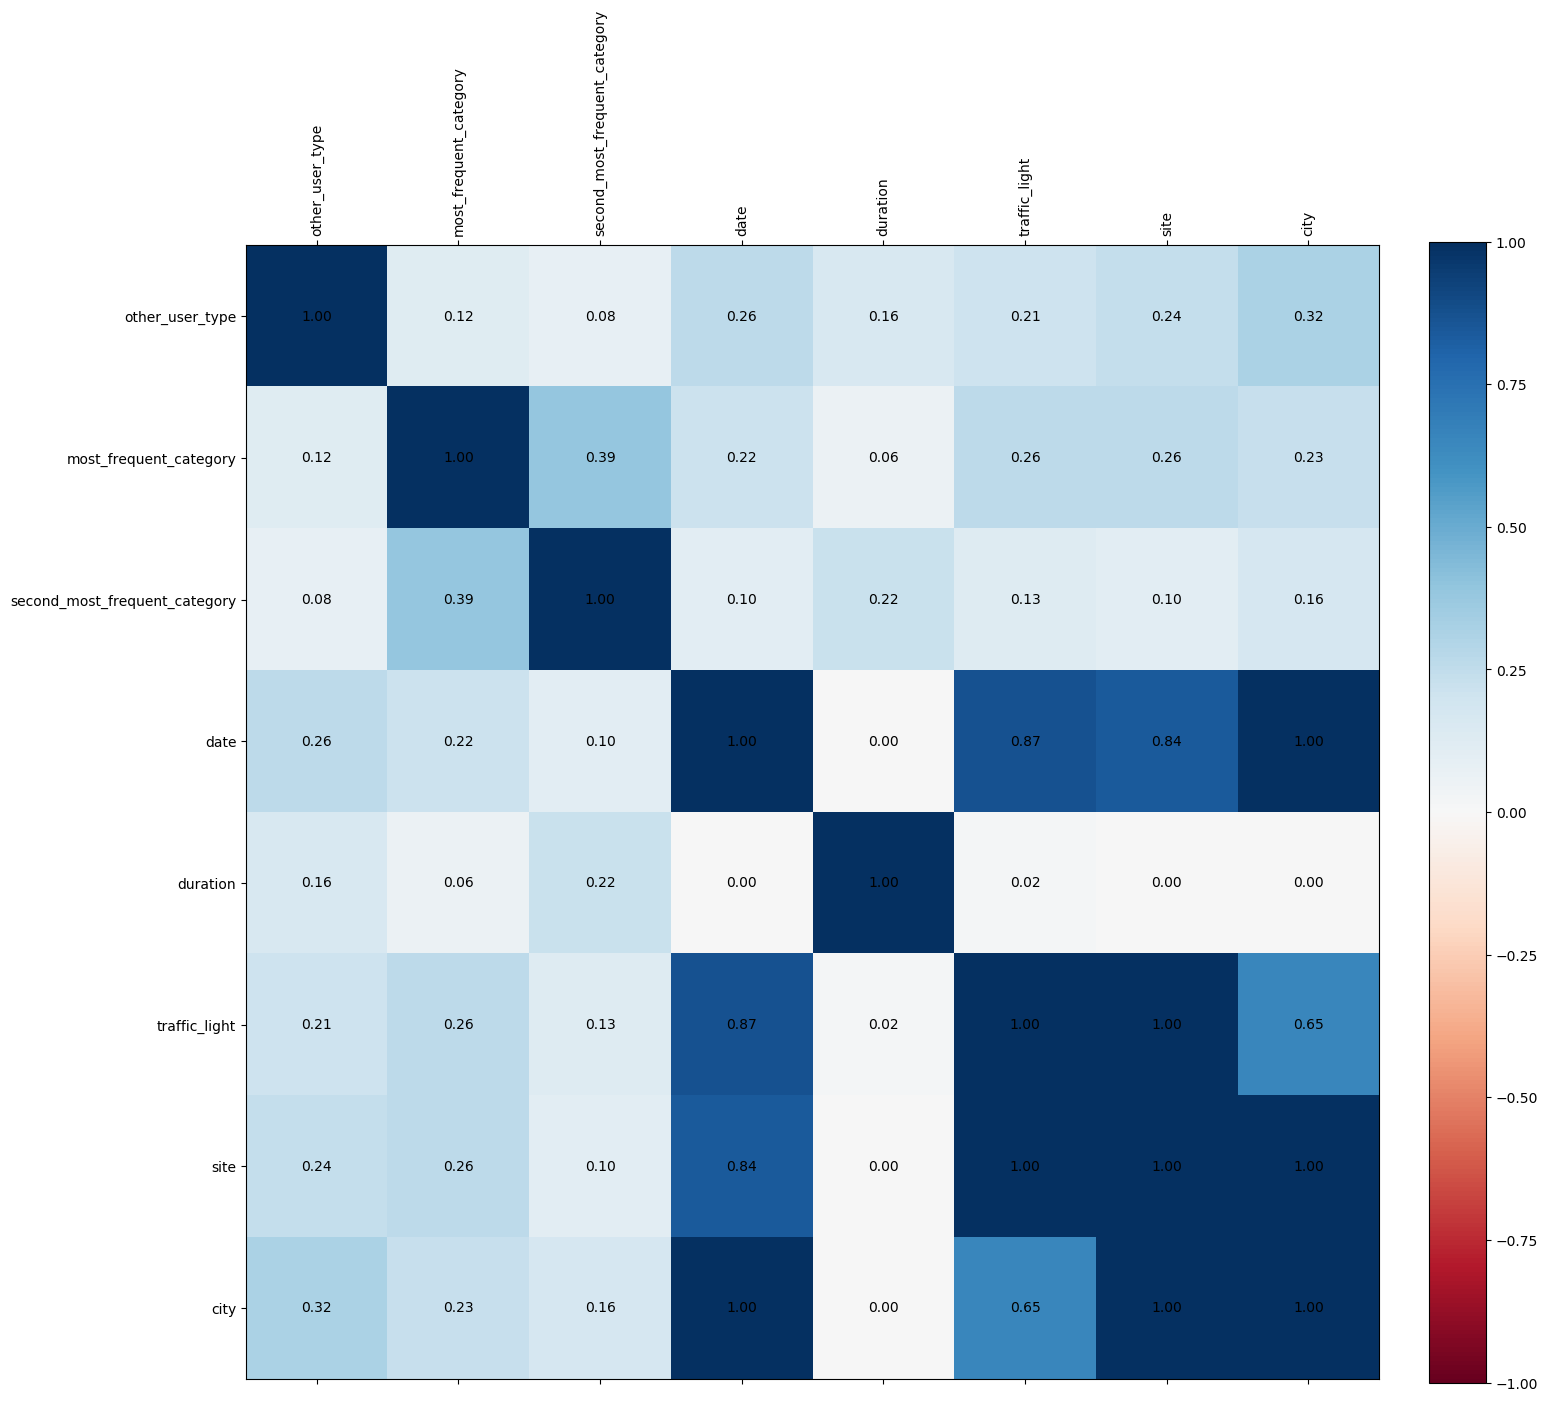

In [29]:
categoricalVariables.remove('interaction_id')
catCorr = categoricalCorrelationMatrix(petTtcSpeedDiff, categoricalVariables)
catCorr = pd.DataFrame(catCorr)
catCorr.columns = categoricalVariables
catCorr.index = categoricalVariables
showCorrelationMatrix(catCorr)
plt.savefig("imgs/corrCramer.pdf", format="pdf", bbox_inches='tight', transparent="True", pad_inches=0)

#### Models

##### 15<sup>th</sup> centile time-to-collision (TTC<sub>15</sub>)

In [30]:
ttcDf = petTtcSpeedDiff.loc[petTtcSpeedDiff.ttc_15 > 0]

In [31]:
m = "C(av) * C(other_user_type) + C(av) * C(most_frequent_category) + u2_min_15_acc * C(site) + u2_max_85_acc * C(site)"

In [32]:
modelTtc = smf.ols('ttc_15 ~ ' + m, data=ttcDf)
results = modelTtc.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 ttc_15   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     13.53
Date:                Mon, 07 Dec 2020   Prob (F-statistic):           1.43e-59
Time:                        20:23:16   Log-Likelihood:                -3554.4
No. Observations:                2281   AIC:                             7169.
Df Residuals:                    2251   BIC:                             7341.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                                                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------

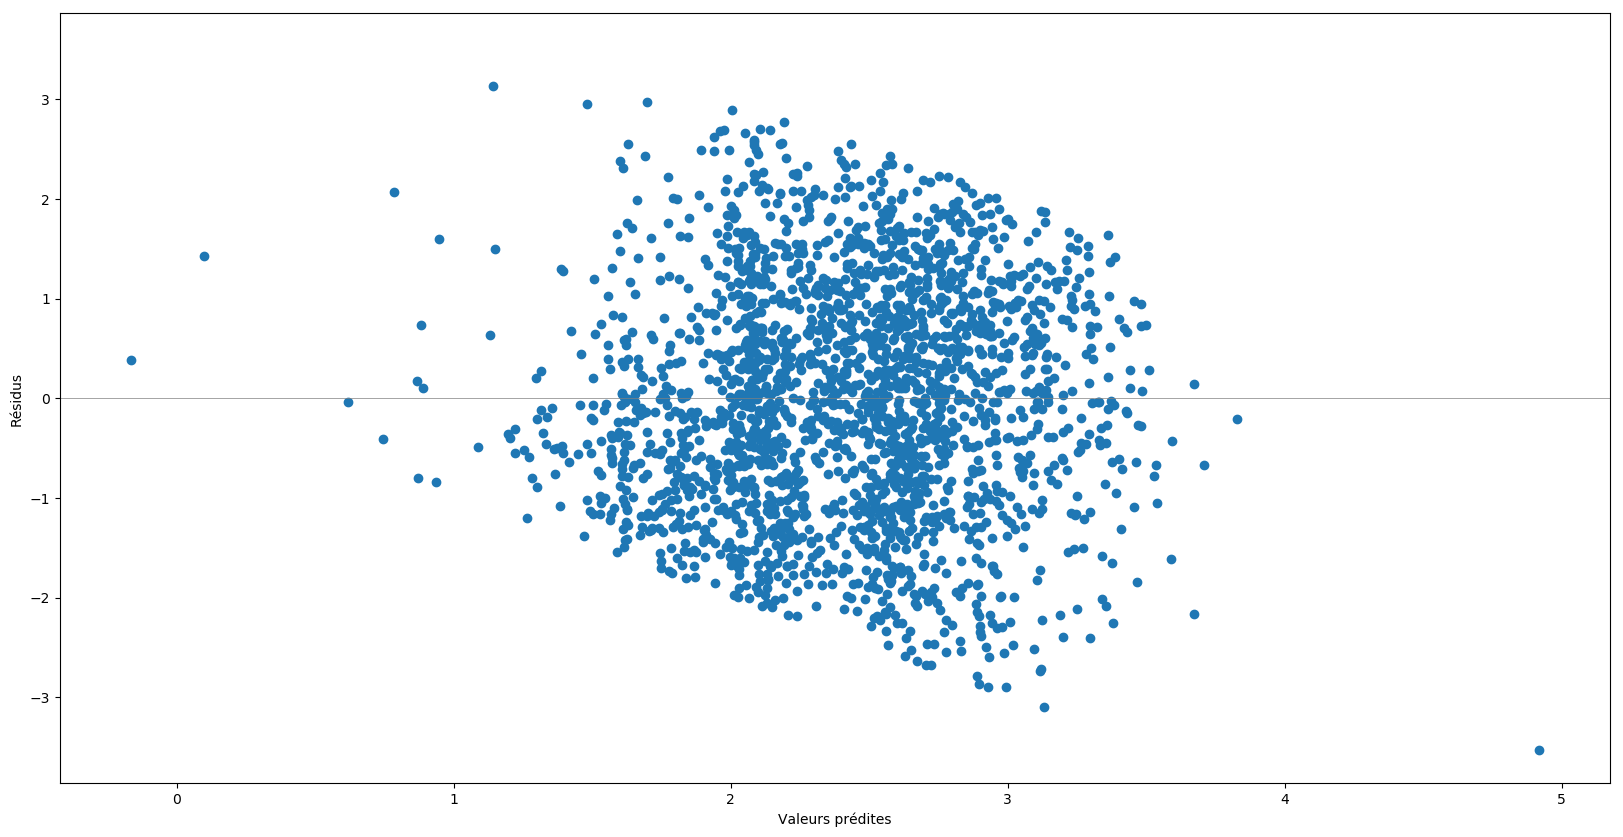

In [33]:
showResidualPlot(results)
plt.savefig("imgs/residusTtc.pdf", format="pdf", bbox_inches='tight', transparent="True", pad_inches=0)

##### Post-encroachment time (PET)

In [34]:
uniquePetValues = np.sort(petTtcSpeedDiff.pet.unique())

# Removing low PET values resulting from bad segmentation
petDf = petTtcSpeedDiff.loc[petTtcSpeedDiff.pet > 0]
petDf = petDf.drop(petDf.loc[petDf.pet == uniquePetValues[0]].index)
petDf = petDf.drop(petDf.loc[petDf.pet == uniquePetValues[1]].index)
petDf = petDf.drop(petDf.loc[petDf.pet == uniquePetValues[2]].index)
petDf = petDf.drop(petDf.loc[(petDf.pet == uniquePetValues[3]) & ((petDf.interaction_id == 103) | (petDf.interaction_id == 32) | (petDf.interaction_id == 37))].index)
petDf = petDf.drop(petDf.loc[(petDf.pet == uniquePetValues[4]) & (petDf.interaction_id == 119)].index)
petDf = petDf.drop(petDf.loc[(petDf.pet == uniquePetValues[5]) & (petDf.interaction_id == 75)].index)

In [35]:
modelPet = smf.ols('np.log(pet) ~ ' + m, data=petDf)
results = modelPet.fit()
print(results.summary())
# print(results.summary().as_latex())

                            OLS Regression Results                            
Dep. Variable:            np.log(pet)   R-squared:                       0.302
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     21.02
Date:                Mon, 07 Dec 2020   Prob (F-statistic):           1.31e-89
Time:                        20:23:17   Log-Likelihood:                -1588.5
No. Observations:                1442   AIC:                             3237.
Df Residuals:                    1412   BIC:                             3395.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                                                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------

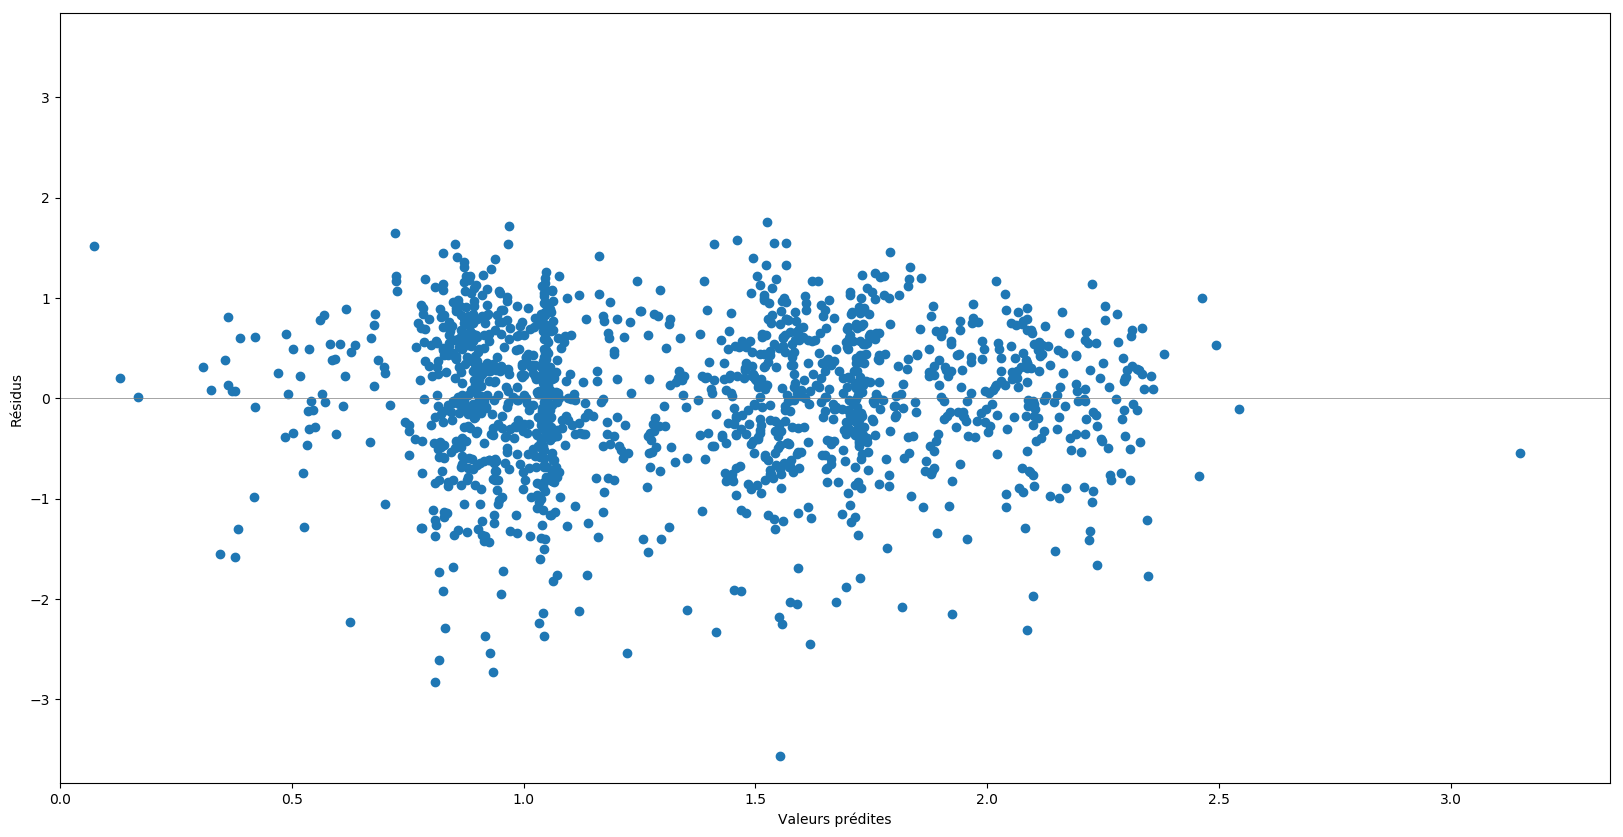

In [36]:
showResidualPlot(results)
plt.xlim(0)
plt.savefig("imgs/residusPet.pdf", format="pdf", bbox_inches='tight', transparent="True", pad_inches=0)

##### Speed differential

In [37]:
m = "C(av) * C(other_user_type) + C(av) * C(most_frequent_category) + u2_min_speed * C(site)"

In [38]:
modelSpeed = smf.ols('speed_diff_max ~ ' + m, data=petTtcSpeedDiff)
results = modelSpeed.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         speed_diff_max   R-squared:                       0.309
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     62.69
Date:                Mon, 07 Dec 2020   Prob (F-statistic):          4.86e-228
Time:                        20:23:18   Log-Likelihood:                -11984.
No. Observations:                3109   AIC:                         2.401e+04
Df Residuals:                    3086   BIC:                         2.415e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------

#### Cumulative coefficients

In [39]:
models = []
models.append(modelTtc)
models.append(modelPet)
models.append(modelSpeed)

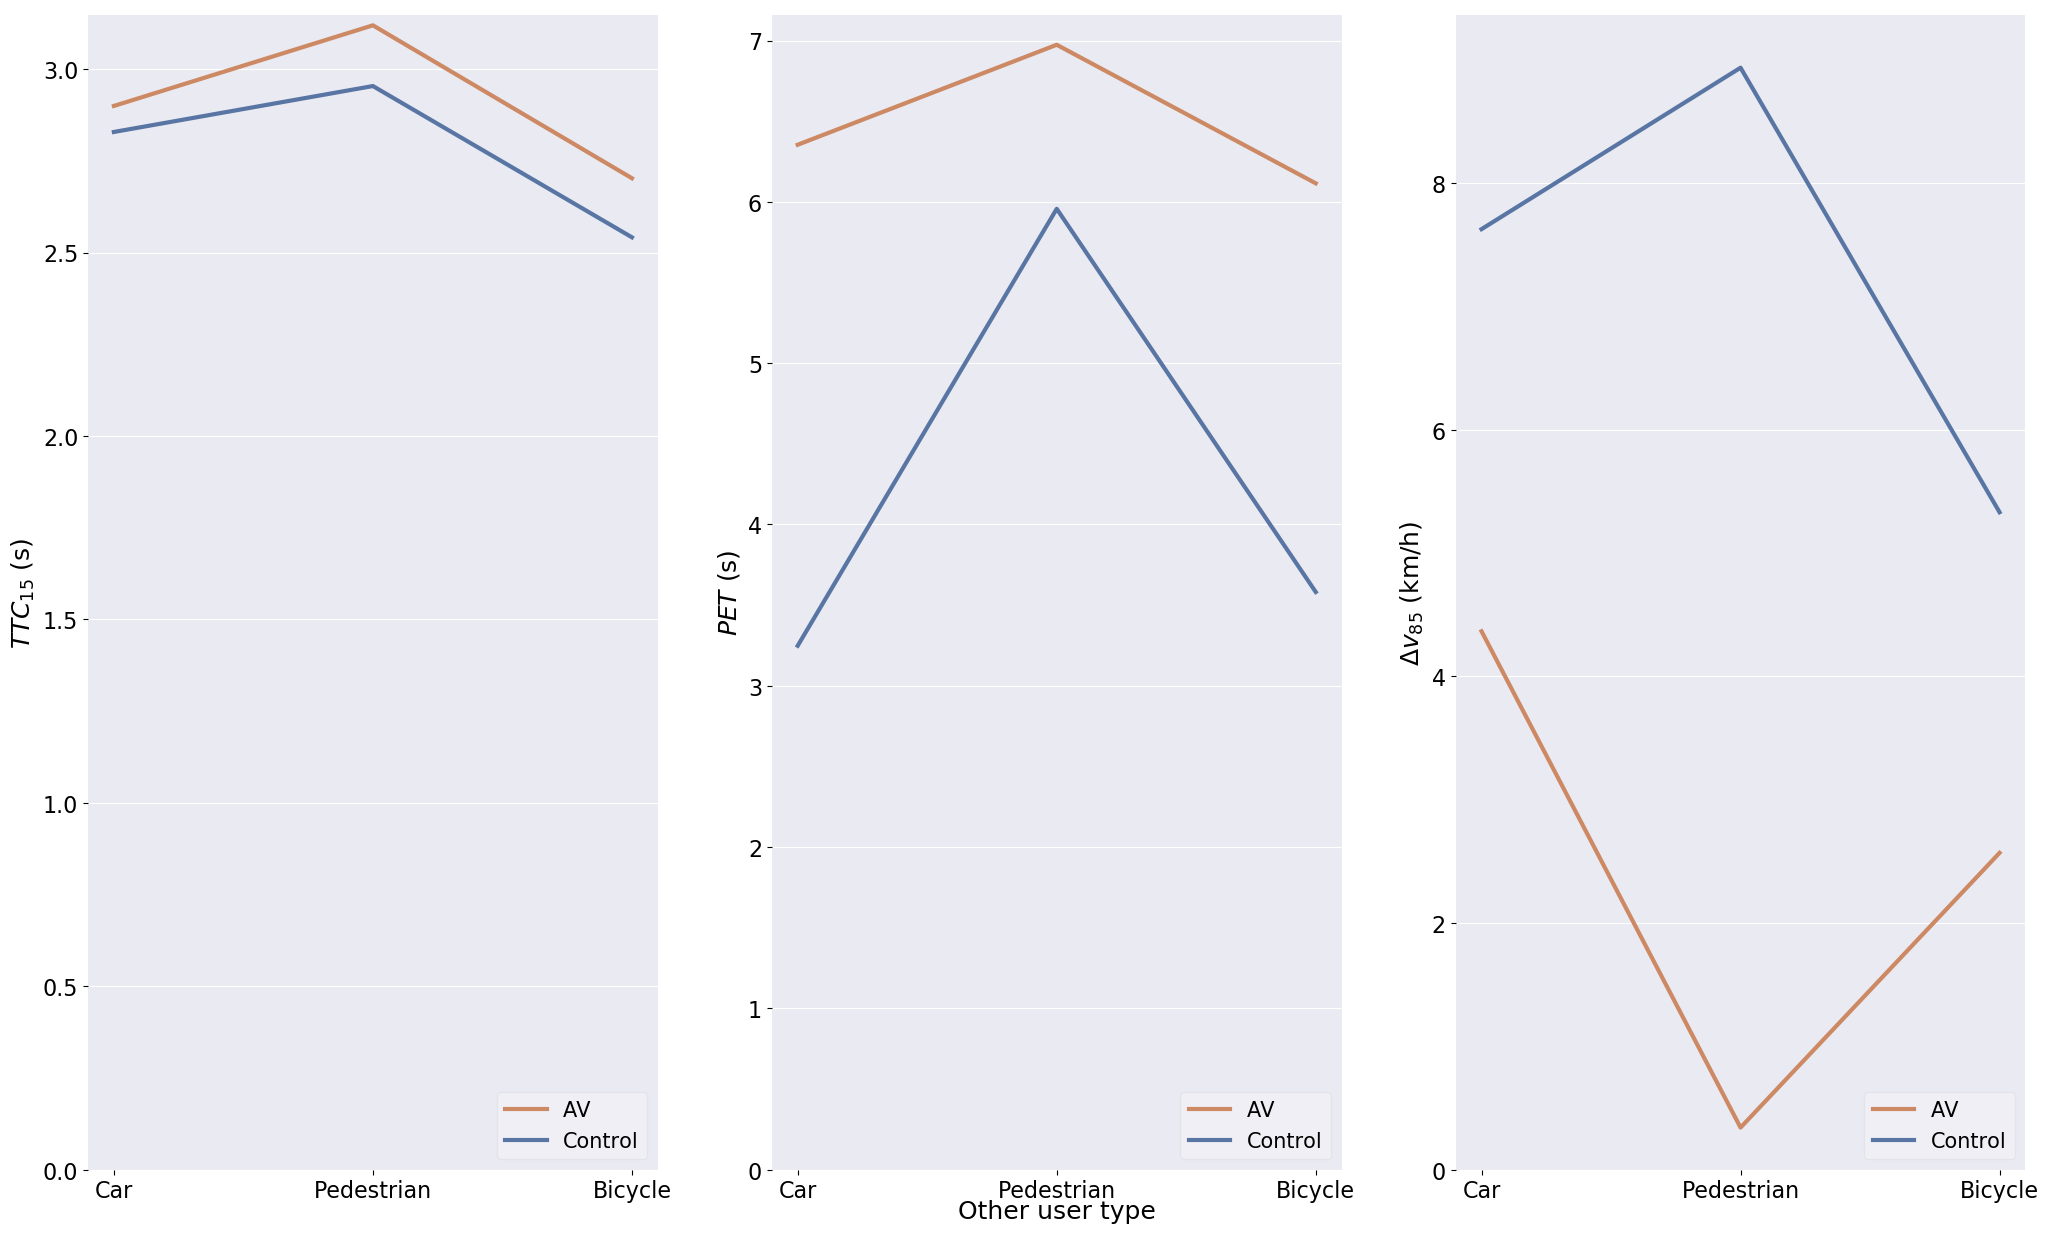

In [40]:
fig = plt.figure(figsize=(25,15))
ax = fig.add_subplot(111)
# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

subplotIndex = 131
x = ["Car", "Pedestrian", "Bicycle"]
for i in range(3):
    results = models[i].fit()
    # Effect of other user type with av on TTC
    avCar = results.params[["Intercept", "C(av)[T.1]", "C(other_user_type)[T.car]", "C(av)[T.1]:C(other_user_type)[T.car]"]].sum()
    avPed = results.params[["Intercept", "C(av)[T.1]", "C(other_user_type)[T.pedestrian]", "C(av)[T.1]:C(other_user_type)[T.pedestrian]"]].sum()
    avBic = results.params[["Intercept", "C(av)[T.1]"]].sum()

    # Effect of other user type with car on TTC
    controlCar = results.params[["Intercept", "C(other_user_type)[T.car]"]].sum()
    controlPed = results.params[["Intercept", "C(other_user_type)[T.pedestrian]"]].sum()
    controlBic = results.params[["Intercept"]].sum()
    
    subAx = fig.add_subplot(subplotIndex)
    
    yAv = [avCar, avPed, avBic]
    yControl = [controlCar, controlPed, controlBic]
    if models[i].endog_names == "np.log(pet)" :
        subAx.set_ylabel("$PET$ (s)", fontsize=18)
        yAv = np.exp(yAv)
        yControl = np.exp(yControl)
    elif models[i].endog_names == "ttc_15" :
        subAx.set_ylabel("$TTC_{15}$ (s)", fontsize=18)
    elif models[i].endog_names == "speed_diff_max" :
        subAx.set_ylabel("$\Delta v_{85}$ (km/h)", fontsize=18)
    
    subAx.plot(x, yAv, label='AV', linewidth=3, color=(204/255,137/255,99/255))
    subAx.plot(x, yControl, label='Control', linewidth=3, color=(88/255,117/255,164/255))
    subAx.set_facecolor((234/255, 234/255, 242/255))  # Background color
    legend = subAx.legend(loc='lower right', prop={'size':15}, framealpha=0.25, frameon=True)
    subAx.yaxis.grid(color=(1,1,1))
    subAx.spines['top'].set_visible(False)
    subAx.spines['right'].set_visible(False)
    subAx.spines['left'].set_visible(False)
    subAx.spines['bottom'].set_visible(False)
    subAx.tick_params(axis='both', which='major', labelsize=16)
    subAx.set_ylim(0)
    
    subplotIndex += 1

# Set common label
ax.set_xlabel("Other user type", fontsize=18)

plt.savefig("imgs/cumulatedBetaEffects.pdf", format="pdf", bbox_inches='tight', pad_inches=0)

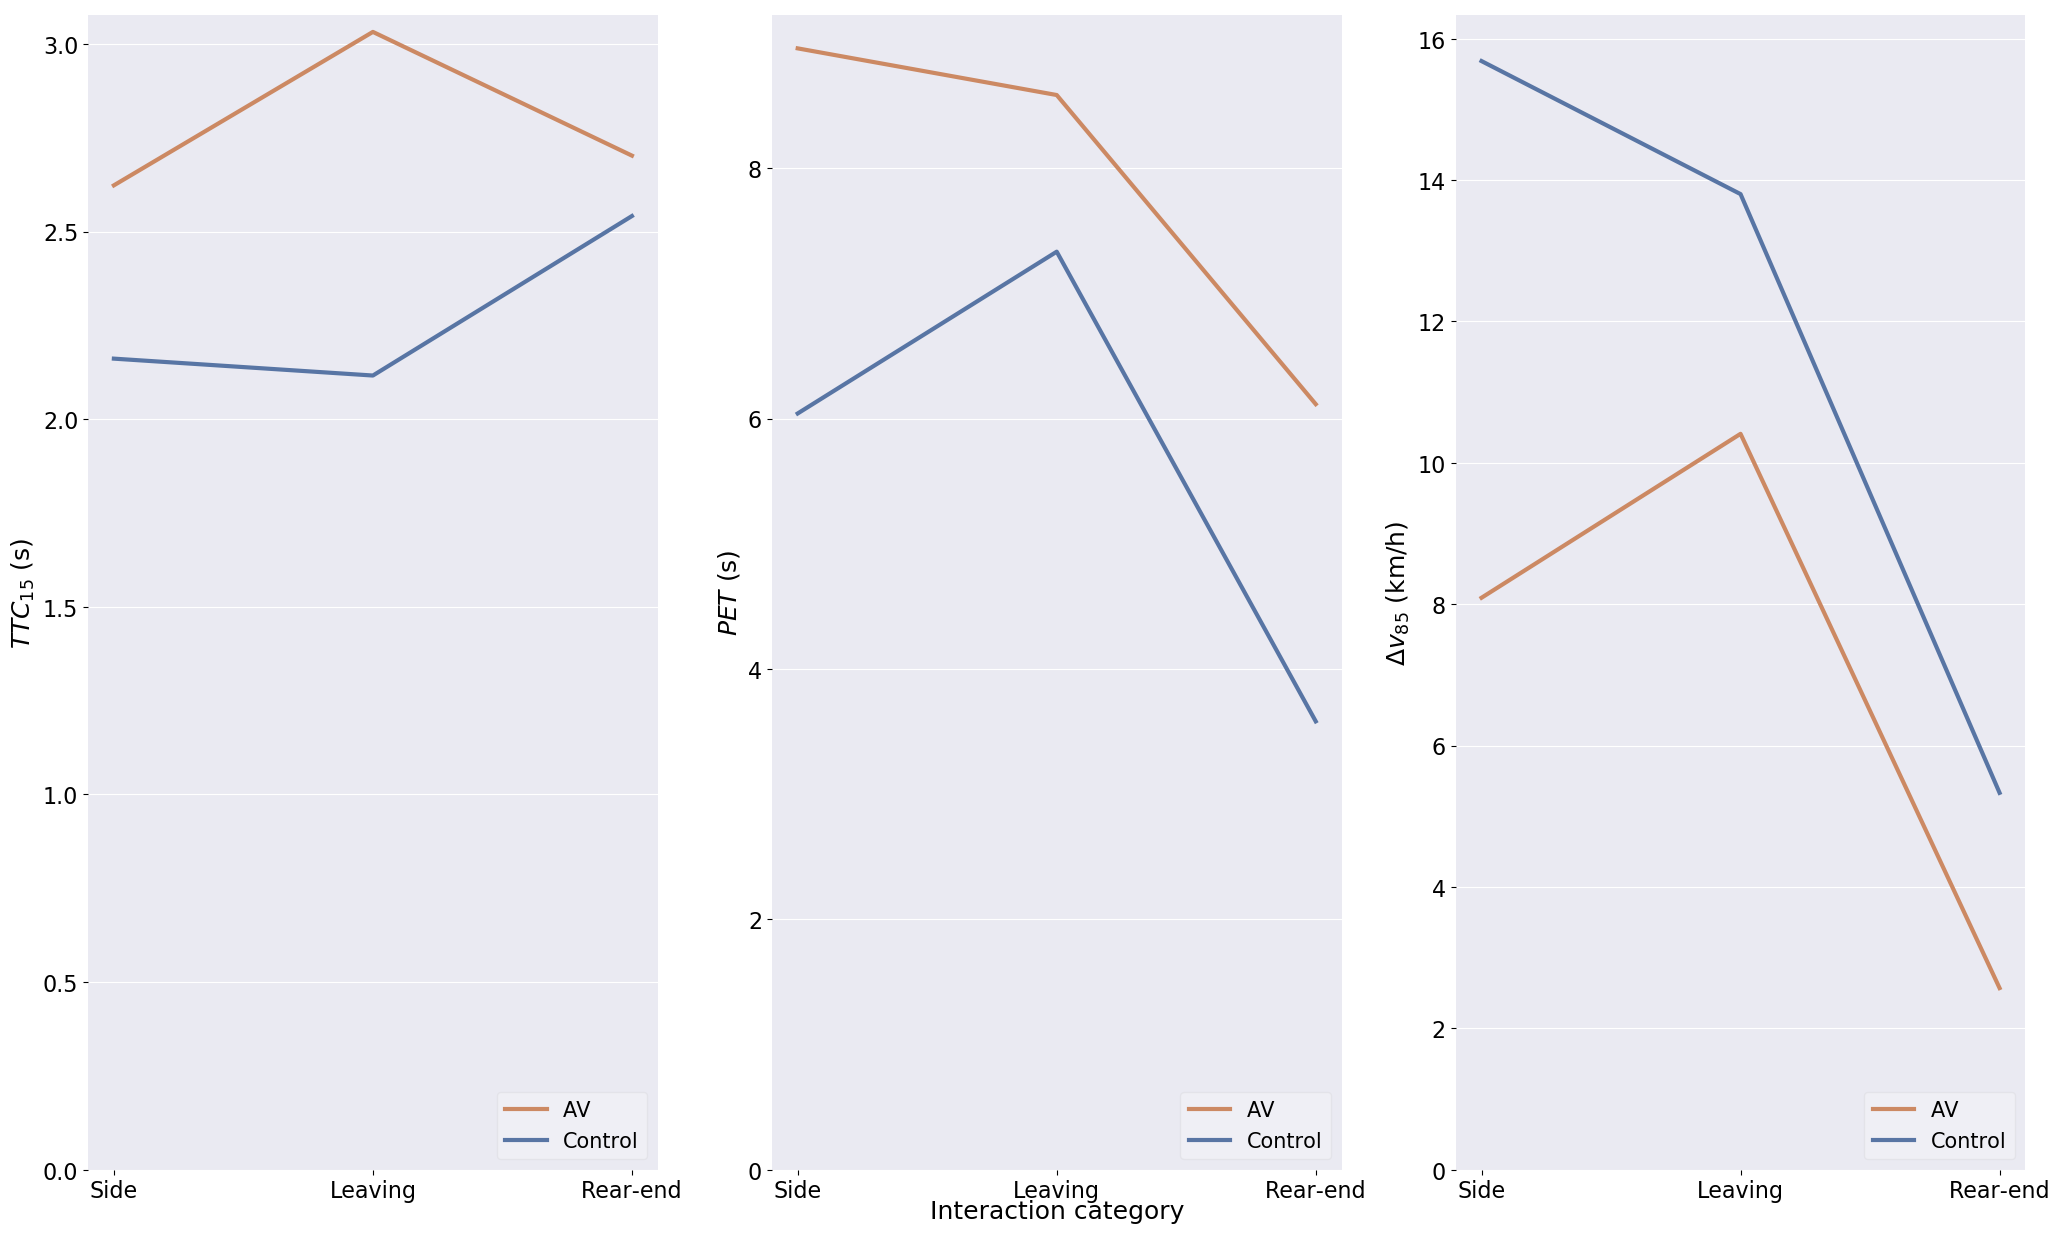

In [41]:
fig = plt.figure(figsize=(25,15))
ax = fig.add_subplot(111)
# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

subplotIndex = 131
x = ["Side", "Leaving", "Rear-end"]
for i in range(3):
    results = models[i].fit()
    # Effect of other user type with av on TTC
    avSide        = results.params[["Intercept", "C(av)[T.1]", "C(most_frequent_category)[T.side]", "C(av)[T.1]:C(most_frequent_category)[T.side]"]].sum()
    avSideleaving = results.params[["Intercept", "C(av)[T.1]", "C(most_frequent_category)[T.sideleaving]", "C(av)[T.1]:C(most_frequent_category)[T.sideleaving]"]].sum()
    avRearend     = results.params[["Intercept", "C(av)[T.1]"]].sum()

    # Effect of other user type with car on TTC
    controlSide        = results.params[["Intercept", "C(most_frequent_category)[T.side]"]].sum()
    controlSideleaving = results.params[["Intercept", "C(most_frequent_category)[T.sideleaving]"]].sum()
    controlRearend     = results.params[["Intercept"]].sum()
    
    subAx = fig.add_subplot(subplotIndex)
    
    yAv = [avSide, avSideleaving, avRearend]
    yControl = [controlSide, controlSideleaving, controlRearend]
    if models[i].endog_names == "np.log(pet)" :
        subAx.set_ylabel("$PET$ (s)", fontsize=18)
        yAv = np.exp(yAv)
        yControl = np.exp(yControl)
    elif models[i].endog_names == "ttc_15" :
        subAx.set_ylabel("$TTC_{15}$ (s)", fontsize=18)
    elif models[i].endog_names == "speed_diff_max" :
        subAx.set_ylabel("$\Delta v_{85}$ (km/h)", fontsize=18)
    
    subAx.plot(x, yAv, label='AV', linewidth=3, color=(204/255,137/255,99/255))
    subAx.plot(x, yControl, label='Control', linewidth=3, color=(88/255,117/255,164/255))
    subAx.set_facecolor((234/255, 234/255, 242/255))  # Background color
    legend = subAx.legend(loc='lower right', prop={'size':15}, framealpha=0.25, frameon=True)
    subAx.yaxis.grid(color=(1,1,1))
    subAx.spines['top'].set_visible(False)
    subAx.spines['right'].set_visible(False)
    subAx.spines['left'].set_visible(False)
    subAx.spines['bottom'].set_visible(False)
    subAx.tick_params(axis='both', which='major', labelsize=16)
    subAx.set_ylim(0)
    
    subplotIndex += 1

# Set common label
ax.set_xlabel("Interaction category", fontsize=18)

plt.savefig("imgs/cumulatedBetaEffectsCategory.pdf", format="pdf", bbox_inches='tight', pad_inches=0)